# Importing all the libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from functools import reduce
import tensorflow as tf
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import sys
import threading
from time import *

import os

In [2]:
#Importing the datasets
mnist_train = pd.read_csv('mnist_train_1.csv')

mnist_test = pd.read_csv('mnist_test_1.csv')   

In [3]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist_test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Let's see the shape of the train and test data
print(mnist_train.shape, mnist_test.shape)

(60000, 785) (10000, 785)


In [6]:
# and yeah, here you will see the basic statistical insights of the numerical features of train data.
mnist_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


In [7]:
mnist_train.isna().any().any()

False

In [8]:
mnist_test.isna().any().any()

False

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255]

In [9]:
# dividing the data into the input and output features to train make the model learn based on what to take in and what to throw out.
mnist_train_data = mnist_train.loc[:, "pixel0":]
mnist_train_label = mnist_train.loc[:, "label"]

# Notmailzing the images array to be in the range of 0-1 by dividing them by the max possible value. 
# Here is it 255 as we have 255 value range for pixels of an image. 
mnist_train_data = mnist_train_data/255.0


# same for test data
mnist_test_data = mnist_test.loc[:, "pixel0":]
mnist_test_label = mnist_test.loc[:, "label"]


mnist_test_data = mnist_test_data/255.0

In [10]:
mnist_train_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
mnist_train_label

0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: label, Length: 60000, dtype: int64

In [12]:
mnist_test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
mnist_test_label

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: label, Length: 10000, dtype: int64

Changing our target to categorical 

In [14]:
y_train = to_categorical(mnist_train_label)

print(f"Label size {y_train.shape}")

y_test = to_categorical(mnist_test_label)

print(f"Label size {y_test.shape}")

Label size (60000, 10)
Label size (10000, 10)


In [15]:
X_train = mnist_train_data.copy()
X_test = mnist_test_data.copy()


In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [17]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [18]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

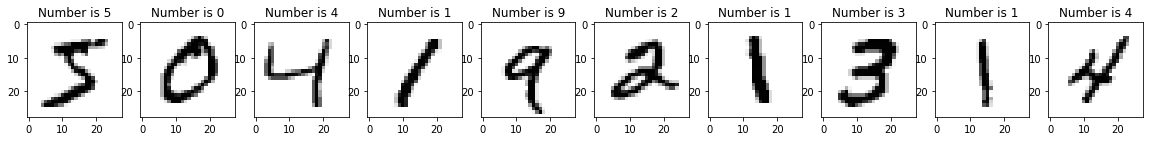

In [19]:
X_for_train = X_train.copy()
X_for_train = X_for_train.reshape(X_for_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 10, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_for_train[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Number is {digit}");

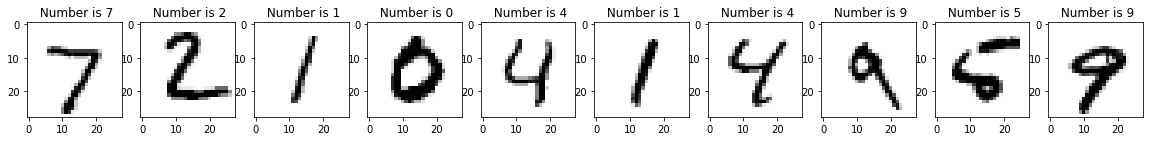

In [20]:
X_for_test = X_test.copy()
X_for_test = X_for_test.reshape(X_for_test.shape[0], 28, 28)
fig, axis = plt.subplots(1, 10, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_for_test[i], cmap='binary')
    digit = y_test[i].argmax()
    ax.set(title = f" Number is {digit}");

D:\Anaconda3\envs\Omkar_new1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


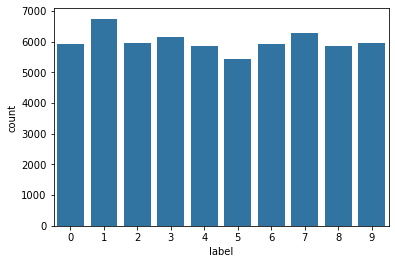

In [21]:
sns.countplot(mnist_train_label, color = sns.color_palette()[0]);

D:\Anaconda3\envs\Omkar_new1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


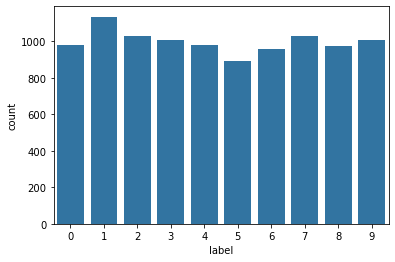

In [22]:
sns.countplot(mnist_test_label, color = sns.color_palette()[0]);

PCA finds a new set of dimensions (or a set of basis of views) such that all the dimensions are orthogonal (and hence linearly independent) and ranked according to the variance of data along them. It means more important principle axis occurs first. (more important = more variance/more spread out data)

How does PCA work -

Calculate the covariance matrix X of data points.
Calculate eigen vectors and corresponding eigen values.
Sort the eigen vectors according to their eigen values in decreasing order.
Choose first k eigen vectors and that will be the new k dimensions.
Transform the original n dimensional data points into k dimensions.

Text(0, 0.5, 'Cumulative explained variance')

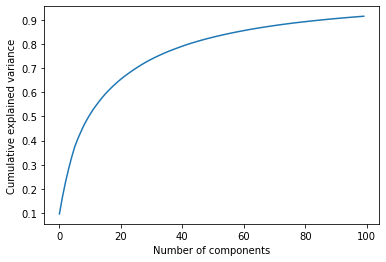

In [23]:
pca = PCA(n_components=100)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

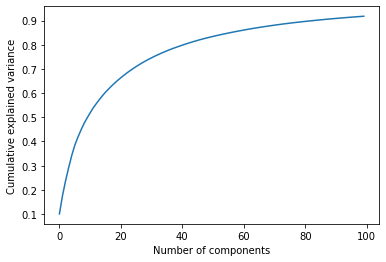

In [24]:
pca_test = PCA(n_components=100)
pca_test.fit(X_test)

plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

0.9143047175531314

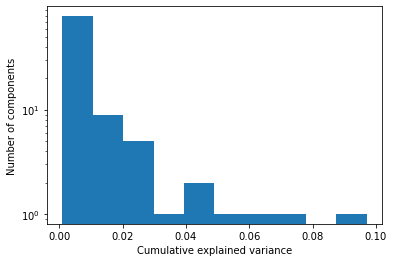

In [25]:
plt.hist(pca.explained_variance_ratio_, log=True)
plt.xlabel('Cumulative explained variance')
plt.ylabel('Number of components')

pca.explained_variance_ratio_.sum()

In [26]:
#to avoid confusion copying the dataset in new variable for decomposition
X_for_decomposition = mnist_train_data.copy()
X = np.array(X_for_decomposition)
#standard scaler for PCA decomposition
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X = scalar.fit_transform(X)
X.shape
#doing pca and storing the result 
pca = PCA(n_components=100)
X_new = pca.fit_transform(X)

In [27]:
inv_pca = pca.inverse_transform(X_new)
inv_sc = scalar.inverse_transform(inv_pca)

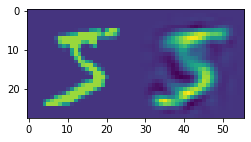

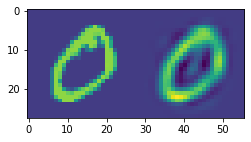

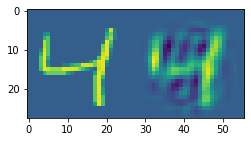

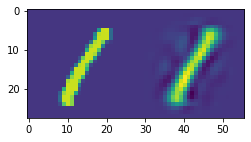

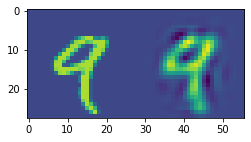

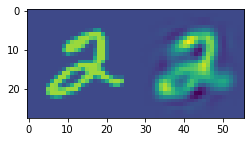

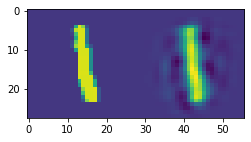

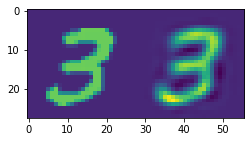

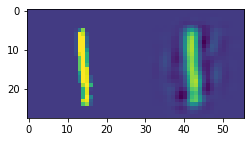

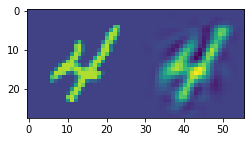

In [28]:
def side_plot(indexes):
    reshape = X_for_train[indexes].reshape(28,28)
    inverse = inv_sc[indexes].reshape(28,28)
    pair = np.concatenate((reshape, inverse), axis=1)
    plt.figure(figsize=(10,2))
    plt.imshow(pair)
    plt.show()
    
for i in range(0,10):
    side_plot(i)

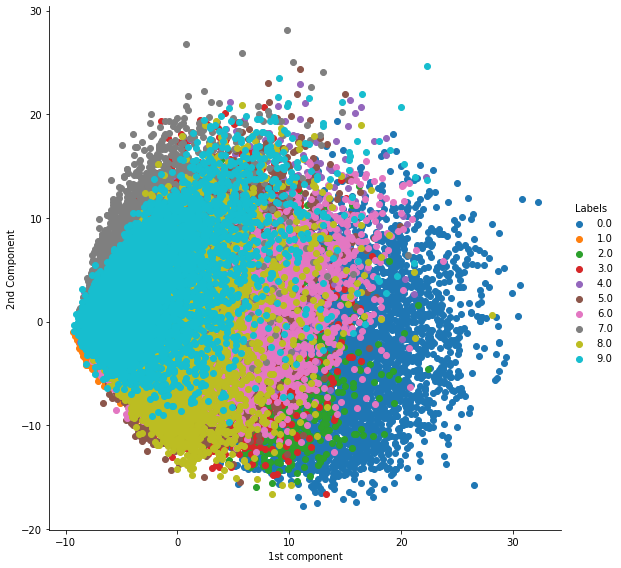

In [29]:
#For checking and learning from first 2 components
y_train_for_plot = mnist_train_label
Vis = np.vstack(((X_new[:, 0], X_new[:, 1]) , y_train_for_plot)).T
dataframe = pd.DataFrame(data=Vis , columns=("1st component", "2nd Component" , "Labels"))
import seaborn as sns
sns.FacetGrid(dataframe , hue='Labels', height=8).map(plt.scatter, '1st component' , '2nd Component').add_legend()
plt.show()

We can see that 100 PCA contains almost 91% of variance however we can see that in the last there is low variance. So we will use only 81 components for our problem

We are going to define a function which will calculate the pca not by the PCA function from sklearn we will calculate it by making a new function and reduce the dimension of our data by parallelization method to improve our modelling

In [30]:
def centering(X):
    mean = X.mean(axis=0)  #finding mean of 784 pixels/rows
    X -= mean[None, :] # changing the dimension from (784, ) to (1, 784) of mean and
                        #then substracting the mean from data ( Centering the data )
    return X


In [31]:
X_new_one_train, X_new_one_test = centering(X_train), centering(X_test)

Now, data set is centered. We will now calculate covariance matrix

In [32]:
#stored this function in file called covar which is imported in the start
def covariance(X):
    n = X.shape[0]
    X_corr = (1 / n-1) * X.T.dot(X)    
    return X_corr


In [33]:

start = time()
correlation_matrix = covariance(X_new_one_train)
print('Time taken: ',time()-start)
correlation_matrix

Time taken:  0.5912458896636963


array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [34]:
def covariance_thread(X):
    n = X.shape[0]
    X_corr = (1 / n-1) * X.T.dot(X)    
    print( X_corr)
    sys.stdout.flush()
    return


In [52]:

if __name__ == '__main__':

    print('parent process:', os.getppid())
    print('process id:', os.getpid())
    start = time()
    p2 = threading.Thread(target=covariance_thread, args=(X_new_one_train,))
    p2.start()
    #p2.join()
    print('Time taken: ',time()-start)

parent process: 3780
process id: 9704
Time taken:  0.00350189208984375
[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


Multiprocessing improves the reliability of the system while in the multithreading process, each thread runs parallel to each other. Multiprocessing helps you to increase computing power whereas multithreading helps you create computing threads of a single process.

Because of this multiprocessing works slower than normal. However multi-threading helps us to compute 10x times faster 

After finding covariance matrix, we will find eigen value and eigen vector of the covariance matrix 

In [36]:
def eigenvector(X):
    
    
    #Computes the singular value decompositions of matrice
    # using tensor flow because numpy takes alot of time and cpu storage to compute
    #s is for  eigen values.
    # u is for  left eigen vectors.
    # v is for right eigen vectors.
    u,s,v = np.linalg.svd(X)
    eig_values, eig_vectors = s, u
   
    return eig_vectors


In [37]:
eigvector = eigenvector(correlation_matrix)

In [38]:
eigvector.shape

(784, 784)

After finding the eigenvector of correlation matrix. Now we will use this eigen vector for reducing the dimension of our original data. We will multiply this eigenvector with our original data to get actual dimension which means Transform the original d dimensional data points into k dimensions.

In [53]:
def dimreduction(X, eigvector, dimension):
    X_new = X.dot(eigvector[:, 0:dimension])
    return X_new

In [40]:
X_train = dimreduction(X_new_one_train, eigvector, 100)
X_test = dimreduction(X_new_one_test, eigvector, 100)

In [41]:
type(X_test), type(X_train)

(numpy.ndarray, numpy.ndarray)

In [42]:
X_train.shape, X_test.shape

((60000, 100), (10000, 100))

In [43]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [44]:
#simple model with categorical loss function and categorical accuracy metrics 

model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(100,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

model.compile(loss = "categorical_crossentropy", optimizer='rmsprop', metrics=['categorical_accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5

In [45]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose = 1, batch_size = 64)

#10 epoch is best as it avoid overfitting and works best, there is no point in increasing number of epoch more than that.

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3296 - categorical_accuracy: 0.9028 - val_loss: 0.1265 - val_categorical_accuracy: 0.9619
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1490 - categorical_accuracy: 0.9567 - val_loss: 0.0937 - val_categorical_accuracy: 0.9710
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1111 - categorical_accuracy: 0.9672 - val_loss: 0.0882 - val_categorical_accuracy: 0.9746
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0921 - categorical_accuracy: 0.9740 - val_loss: 0.0795 - val_categorical_accuracy: 0.9779
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0836 - categorical_accuracy: 0.9761 - val_loss: 0.0787 - val_categorical_accuracy: 0.9791
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0740 - categorical_accuracy: 0.9794 - val_loss: 0.0770 - val_categorical_accuracy: 0.9799
Epoc

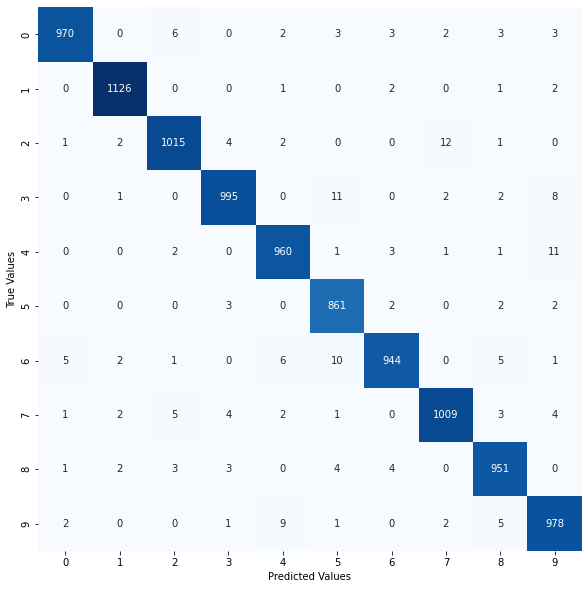

In [46]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

conf = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(conf.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [47]:
#function for plotting classfication report
def classification(model, X_val, y_val):
    #get the predictions for the test data
    predicted_classes = np.argmax(model.predict(X_val), axis=-1)
    #get the indices to be plotted
    y_true = np.argmax(y_val,axis=1)
    correct = np.nonzero(predicted_classes==y_true)[0]
    incorrect = np.nonzero(predicted_classes!=y_true)[0]
    
    print("Correct predicted classes:",correct.shape[0])
    print("Incorrect predicted classes:",incorrect.shape[0])
    target = ["Class {}:".format(i) for i in range(10)]
    print(classification_report(y_true, predicted_classes, target_names=target))
    

In [48]:
classification(model, X_test, y_test)

Correct predicted classes: 9809
Incorrect predicted classes: 191
              precision    recall  f1-score   support

    Class 0:       0.98      0.99      0.98       980
    Class 1:       0.99      0.99      0.99      1135
    Class 2:       0.98      0.98      0.98      1032
    Class 3:       0.98      0.99      0.98      1010
    Class 4:       0.98      0.98      0.98       982
    Class 5:       0.99      0.97      0.98       892
    Class 6:       0.97      0.99      0.98       958
    Class 7:       0.98      0.98      0.98      1028
    Class 8:       0.98      0.98      0.98       974
    Class 9:       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



We got the Best model. Now lets plot first 20 images with prediction and actual result. 

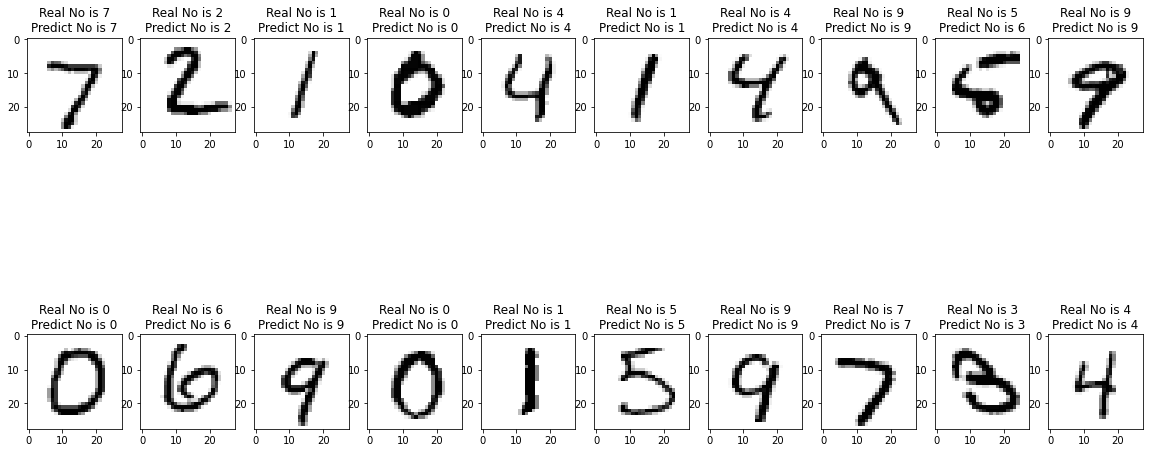

In [49]:
fig, axis = plt.subplots(2, 10, figsize=(20, 10))
for i, ax in enumerate(axis.flat):   # For each iteration it would yield the next axes from that array, such that you may easily plot to all axes in a single loop.
    ax.imshow(X_for_test[i], cmap='binary')
    
    ax.set(title = f"Real No is {y_test[i].argmax()}\nPredict No is {y_pred[i].argmax()}");


In [50]:
predicted_classes_for_plot = np.argmax(model.predict(X_test), axis=-1)

#get the indices to be plotted
y_true_plot = np.argmax(y_test,axis=1)
incorrect_for_plot = np.nonzero(predicted_classes_for_plot!=y_true_plot)[0]
    

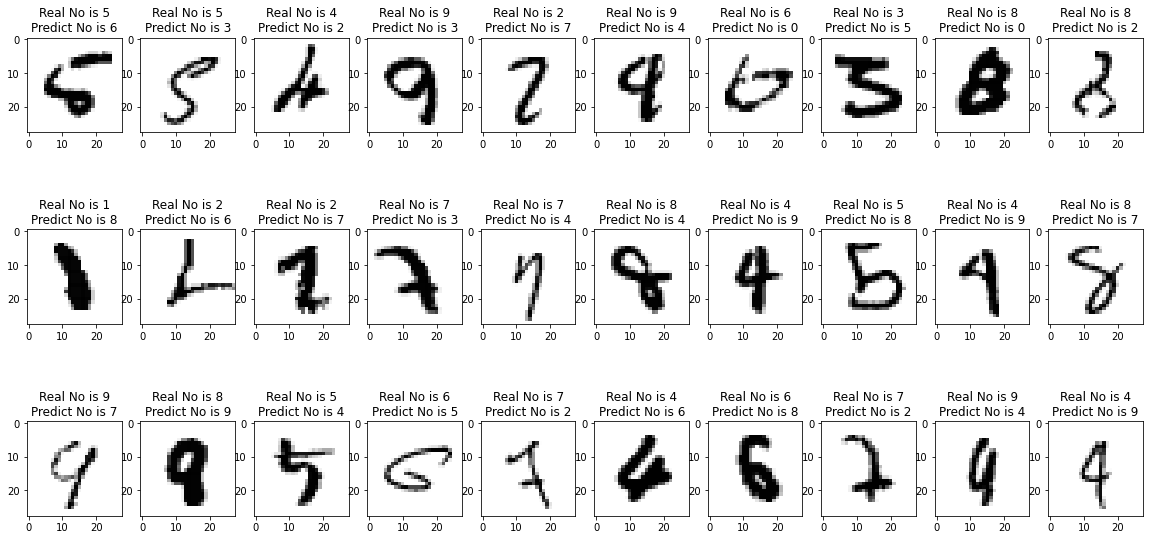

In [51]:
# PLOTTING INCORRECT PREDICTIONS

fig, axis = plt.subplots(3, 10, figsize=(20, 10))

for i, ax in enumerate(axis.flat):
    ax.imshow(X_for_test[incorrect_for_plot[i]], cmap='binary')
    ax.set(title = f"Real No is {y_test[incorrect_for_plot[i]].argmax()}\nPredict No is {y_pred[incorrect_for_plot[i]].argmax()}");
    